### 여러분들은 자금을 받아 펀드를 운용하는 펀드매니저입니다. 어느날, 한 고객이 찾아와 돈을 맡기면서 다음의 조건에 맞는 포트폴리오를 구성해달라고 합니다. 이를 바탕으로 다음의 질문에 답하시오.

- 다음의 주식들로 포트폴리오를 구성: 삼성전자, NC소프트, SK하이닉스, 카카오, 네이버
- 2019.1.1 ~ 2020.1.1의 일별데이터를 사용.
- 수익률은 ${P_t - P_{t-1}}\over{P_{t-1}}$로 구함. 이때, $t$는 daily frequency를 의미함.
- 위험자산 중 60%는 삼성전자, KB금융, 롯데칠성 주식으로 구성(무위험자산은 고려 x).
- 포트폴리오에 포함되는 모든 자산의 가중치는 0 ~ 100% 사이.
- 위험 한 단위 대비 기대수익률이 가장 높은 포트폴리오를 구성.

'\nMean-variance frontier는 이 점들의 표면을 이어놓은 점들 (이라고 따로 기술하거나 직접 plot로 그려줘야 함)\n'

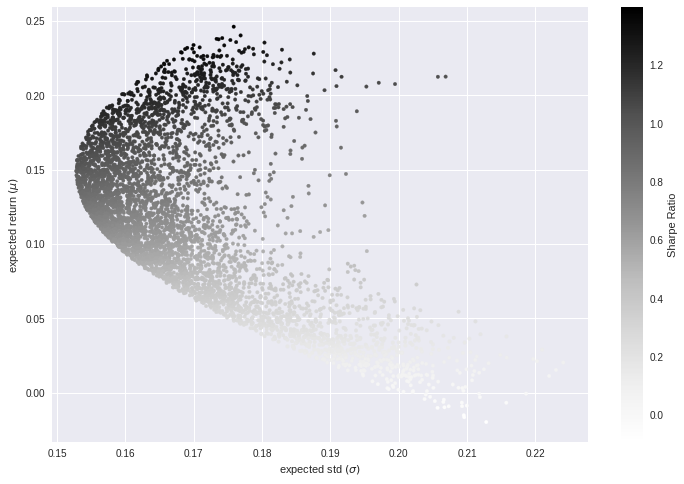

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web
import datetime

def ret_std(weight, ret) :
    port_mean = np.sum(weight * ret.mean() * 252) # 가중치 * 일별 수익률의 평균 
    port_var = np.dot(weight.T , np.dot(ret.cov() * 252 , weight)) 
    #분산을 구하기 위해서는 행렬 간의 곱을 해야하므로 np.dot() 메소드 사용
    port_std = np.sqrt(port_var)
    return port_mean, port_std

port_rets = []
port_std = []

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
data = pd.DataFrame()

for code in ['005930', '005300', '105560', '068270', '035760'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start, end)['Close'].apply(int)], axis = 1)

data.columns = ['se', 'lote', 'kb', 'cell', 'cjem']
'''
for code in ['005930', '036570', '000660', '035720', '035420'] :
    data = pd.concat([data, web.DataReader(code, 'naver', start, end)['Close'].apply(int)], axis = 1)

data.columns = ['se', 'ncs', 'skh', 'kko', 'nvr']
'''
noa = len(data.columns)
ret = data.pct_change().dropna()

for i in range(5000) :
    rweight1 = np.random.random(2) #난수를 만들어줘야지!
    rweight1 /= sum(rweight1)
    rweight1 *= 0.6
    weight = np.array([])
    weight = np.append(weight, rweight1)
    
    rweight2 = np.random.random(3) #난수를 만들어줘야지!
    rweight2 /= sum(rweight2)
    rweight2 *= 0.4
    weight = np.append(weight, rweight2)

    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sr = np.array(port_rets) / np.array(port_std)

plt.style.use('seaborn')
plt.figure(figsize = (12, 8))
plt.scatter(port_std, port_rets, 
            c = np.array(port_rets) / np.array(port_std),marker = '.')
'''
plt.plot(tvols, trets)
plt.legend()
'''
plt.grid(True)
plt.ylabel('expected return $(μ)$')
plt.xlabel('expected std $(σ)$')
plt.colorbar(label = 'Sharpe Ratio')
'''
Mean-variance frontier는 이 점들의 표면을 이어놓은 점들 (이라고 따로 기술하거나 직접 plot로 그려줘야 함)
'''

In [40]:
import scipy.optimize as opt

def statistics(weight, rf = 0) :
    weight = np.array(weight)
    pret = np.dot(weight, ret.mean()) * 252 - rf
    pvol = np.sqrt(np.dot(weight.T, np.dot(ret.cov() * 252, weight)))
    return np.array([pret, pvol, pret/pvol])
    #[0] : 기대수익률, [1] : 분산 [2] : Sharpe Ratio

def min_func_port(weight) :
    return statistics(weight)[1]
    #분산

cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret},
        {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1},
        {'type' : 'eq', 'fun' : lambda x : x[0] + x[1] - 0.6})
#제약식 1 : 포트폴리오 기대수익률 - 개별자산 기대수익률 

bnds = [(0, 0.6) for x in range(noa - 3)] + [(0, 0.4) for x in range(noa - 2)]

trets = np.linspace(0.05, 0.275, 30) #앞선 예시에서 본 범위를 linspace로 설정
tvols = []

#수익률 범위 0.33 ~ 0.44에 대해
for tret in trets :
    cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret}, 
            {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1},
            {'type' : 'eq', 'fun' : lambda x : x[0] + x[1] - 0.6})
    res = opt.minimize(min_func_port, noa * [1 / noa,], method = 'SLSQP',
                       bounds = bnds, constraints = cons)
    tvols.append(res['fun'])
    print(res['x'].round(3))

tvols = np.array(tvols)

[0.167 0.433 0.078 0.063 0.259]
[0.183 0.417 0.089 0.063 0.248]
[0.198 0.402 0.1   0.062 0.238]
[0.214 0.386 0.11  0.062 0.227]
[0.229 0.371 0.121 0.062 0.217]
[0.245 0.355 0.132 0.062 0.206]
[0.26  0.34  0.142 0.062 0.196]
[0.276 0.324 0.153 0.062 0.185]
[0.291 0.309 0.164 0.062 0.175]
[0.307 0.293 0.174 0.061 0.164]
[0.322 0.278 0.185 0.061 0.154]
[0.338 0.262 0.195 0.061 0.143]
[0.353 0.247 0.207 0.06  0.133]
[0.368 0.232 0.218 0.06  0.122]
[0.384 0.216 0.228 0.06  0.112]
[0.399 0.201 0.239 0.06  0.101]
[0.415 0.185 0.25  0.06  0.091]
[0.43 0.17 0.26 0.06 0.08]
[0.446 0.154 0.271 0.059 0.07 ]
[0.461 0.139 0.281 0.059 0.059]
[0.477 0.123 0.292 0.059 0.049]
[0.492 0.108 0.303 0.059 0.038]
[0.508 0.092 0.313 0.059 0.028]
[0.524 0.076 0.324 0.059 0.017]
[0.539 0.061 0.334 0.059 0.007]
[0.557 0.043 0.343 0.057 0.   ]
[0.577 0.023 0.348 0.052 0.   ]
[0.598 0.002 0.353 0.047 0.   ]
[0.598 0.    0.4   0.002 0.   ]
[0.585 0.    0.4   0.015 0.   ]


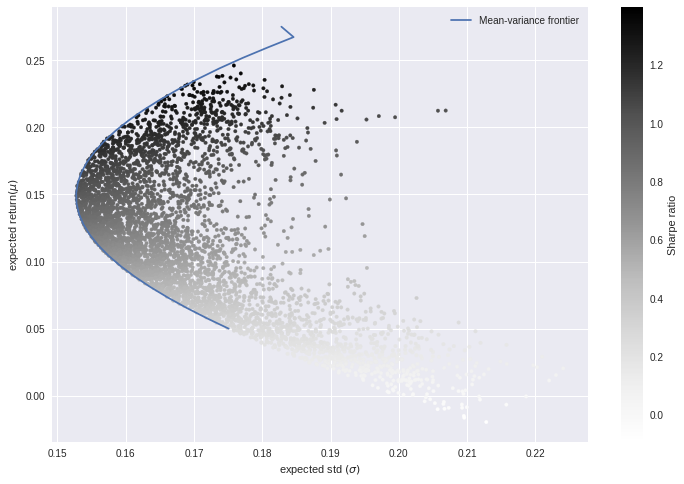

In [41]:
plt.figure(figsize = (12, 8))
plt.scatter(port_std, port_rets, c = np.array(port_rets) / np.array(port_std),
            marker = '.')
plt.plot(tvols, trets, label = 'Mean-variance frontier')
plt.legend()
plt.grid(True)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$')
plt.colorbar(label='Sharpe ratio')

2. Risk-free rate이 0.02 일때, 무위험자산까지 포함한 mean-variance frontier를 도출하고 최적 포트폴리오의 annualized sharpe-ratio를 구하시오 (1년을 252일로 계산).

In [42]:
# 1. N개의 위험 자산들 각각의 가중치 계산
# 2. 도출해낸 가중치들을 바탕으로 무위험자산을 포함한 포트폴리오 구성
# 3. 무위험자산과 포트폴리오간의 자산 배분 비율 계산

import scipy.optimize as opt

#5개의 위험자산들을 조합하여 Sharpe Ratio가 극대화되는 지점을 찾는 함수
def min_func_sharpe(weight, rf = 0.02) :
    return -statistics(weight, rf)[2]
    #[2] : Sharpe Ratio, -를 붙이는건 극대화 지점을 찾기 위해

cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1}, 
        {'type' : 'eq', 'fun' : lambda x : x[0] + x[1] - 0.6})
#제약식 1 : 모든 가중치들의 합은 1 / 제약식 2 : np.dot(weight, ret.mean()) -  pret

bnds = [(0, 0.6) for x in range(noa - 3)] + [(0, 0.4) for x in range(noa - 2)]
#범위 : 자산 1 0.6, 자산 2~5 : 0 ~ 0.4

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method = 'SLSQP',
                    bounds = bnds, constraints = cons)

# scipy.optimize.minimize(fun, x0, args=(), method=None, bounds=None, constraints=())
# noa * [1. / noa, ] : x0 (초기 실행값)
#-> [1. / noa, ] : [1 / noa] : 리스트, [1. / noa] * noa -> noa개 만큼의 1/noa 설정
opts['x'].round(3)

array([0.6  , 0.   , 0.391, 0.009, 0.   ])

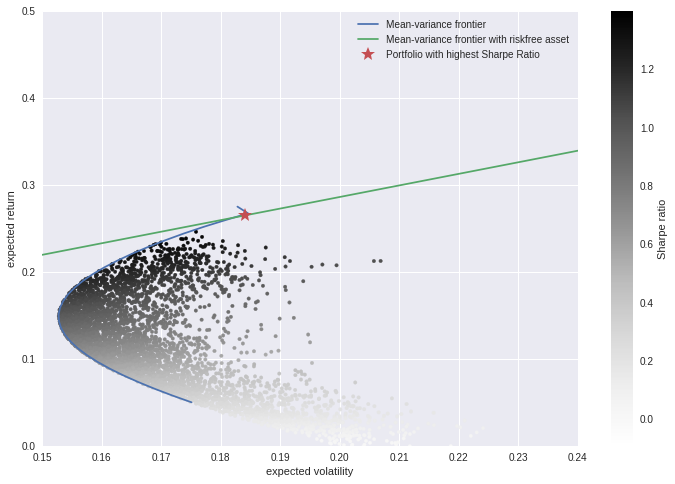

In [43]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
# slope = Sharpe Ratio
# 최적화된 가중치 입력 : statistics(opts['x'])
# 개별자산 [0] - rf / 개별자산

var_list = [x * slope + rf for x in np.linspace(0.15, 0.24, 2500)]
# mu = slope * x + r_f (x : sigma of portfolio, 0.16 ~ 0.24)
# linspace의 범위 : 1번에서 나온 plot의 std의 범위 0.16 ~ 0.24 (샘플 개수는 자유)
# 이는 x축에 대해서도 동일하게 적용해준다 (y에서 설정한 샘플개수와 동일하게 설정한다)

x = np.linspace(0.15, 0.24, 2500)
y = var_list

plt.figure(figsize=(12, 8))

# Mean-variance frontier for only risky assets
plt.plot(tvols, trets, label = 'Mean-variance frontier')

# Random Portfolio 산포도 그리기
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='.')

# CML : random portfolio which includes risk-free asset composition
# set x = (0.16, 0.24), y : mu = slope * x + r_f
plt.plot(x, y, label = 'Mean-variance frontier with riskfree asset')

# Tangency Portfolio
# random portfolio only with risky assets with highest Sharpe ratio
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.xlim((0.15, 0.24))
plt.ylim((0, 0.5))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')   

In [44]:
slope

1.3304376164034004